In [2]:
%matplotlib inline
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import re

import torch

from IPython.display import display, Image

import pandas as pd

import numpy as np

In [3]:
import torchvision
import torch.nn.functional as F

In [4]:
import sys
sys.path.append('../')
from output_utils import *

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
runs = getruns('../Laborieux-Arch/results/EP/*/*/*/')

In [7]:
runsdf = pd.DataFrame(runs)
runsdf.sort_values('test', ascending=False)[['task', 'model', 'test', 'train', 'softmax', 'loss', 'load_path', 'epochs', 'load_path_convert', 'competitiontype', 'inhibitstrength', 'pools', 'lat_constraints', 'dir']]

task       model  test  train  softmax loss load_path  epochs  \
2  CIFAR10  LatSoftCNN 79.71  91.98    False  mse               120   
1  CIFAR10  LatSoftCNN 79.43  88.31    False  mse               120   
0  CIFAR10         CNN 72.75  71.39     True  cel               120   

  load_path_convert         competitiontype  inhibitstrength pools  \
2                    feature_inner_products             1.00  mmmm   
1                    feature_inner_products             1.00  mmmm   
0                                      none             0.00  mmmm   

  lat_constraints                                                dir  
2      [zerodiag]  ../Laborieux-Arch/results/EP/mse/2023-07-24/23...  
1      [zerodiag]  ../Laborieux-Arch/results/EP/mse/2023-07-24/23...  
0              []  ../Laborieux-Arch/results/EP/cel/2023-07-24/or...

In [8]:
path = '../Laborieux-Arch/results/EP/mse/2023-07-24/23-13-24_gpu0_23epochs/'
lattest = runsdf[runsdf['dir'] == path]
latmodel = torch.load(path + 'model.pt')
lattest

model     task pools           archi              channels  \
1  LatSoftCNN  CIFAR10  mmmm  [784, 512, 10]  [128, 256, 512, 512]   

        kernels       strides      paddings    fc          act  ... head_lrs  \
1  [3, 3, 3, 3]  [1, 1, 1, 1]  [1, 1, 1, 0]  [10]  my_hard_sig  ...       []   

  lat_wds save_nrn  load_path_convert convert_place_layers tensorboard  train  \
1    None    False                                      []       False  88.31   

   test                                                dir  \
1 79.43  ../Laborieux-Arch/results/EP/mse/2023-07-24/23...   

                                                call  
1  ../main.py --model LatSoftCNN --task CIFAR10 -...  

[1 rows x 52 columns]

In [9]:
path = '../Laborieux-Arch/results/EP/cel/2023-07-24/origcodebase_09-30-41_gpu0_15epochs/'
controltest = runsdf[runsdf['dir'] == path]
controlmodel = torch.load(path + 'model.pt')
controltest

model     task pools           archi              channels       kernels  \
0   CNN  CIFAR10  mmmm  [784, 512, 10]  [128, 256, 512, 512]  [3, 3, 3, 3]   

        strides      paddings    fc          act  ... head_lrs lat_wds  \
0  [1, 1, 1, 1]  [1, 1, 1, 0]  [10]  my_hard_sig  ...       []    None   

  save_nrn  load_path_convert convert_place_layers tensorboard  train  test  \
0    False                                      []       False  71.39 72.75   

                                                 dir  \
0  ../Laborieux-Arch/results/EP/cel/2023-07-24/or...   

                                                call  
0  main.py --model CNN --task CIFAR10 --data-aug ...  

[1 rows x 52 columns]

In [10]:
mbs = lattest.mbs.item()
T1 = lattest.T1.item()
device = torch.device(lattest.device.item())

In [11]:
if controltest.task.item()=='MNIST':
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

    mnist_dset_train = torchvision.datasets.MNIST('./mnist_pytorch', train=True, transform=transform, target_transform=None, download=True)
    train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=mbs, shuffle=True, num_workers=0)

    mnist_dset_test = torchvision.datasets.MNIST('./mnist_pytorch', train=False, transform=transform, target_transform=None, download=True)
    test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=200, shuffle=False, num_workers=0)

elif controltest.task.item()=='CIFAR10':
    if controltest.data_aug.item():
        transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(0.5),
                                                          torchvision.transforms.RandomCrop(size=[32,32], padding=4, padding_mode='edge'),
                                                          torchvision.transforms.ToTensor(),
                                                          torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                                                           std=(3*0.2023, 3*0.1994, 3*0.2010)) ])
    else:
         transform_train = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                          torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                                                           std=(3*0.2023, 3*0.1994, 3*0.2010)) ])

    transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                     torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                                                      std=(3*0.2023, 3*0.1994, 3*0.2010)) ])

    cifar10_train_dset = torchvision.datasets.CIFAR10('./cifar10_pytorch', train=True, transform=transform_train, download=True)
    cifar10_test_dset = torchvision.datasets.CIFAR10('./cifar10_pytorch', train=False, transform=transform_test, download=True)

    # For Validation set
    val_index = np.random.randint(10)
    val_samples = list(range( 5000 * val_index, 5000 * (val_index + 1) ))

    #train_loader = torch.utils.data.DataLoader(cifar10_train_dset, batch_size=mbs, sampler = torch.utils.data.SubsetRandomSampler(val_samples), shuffle=False, num_workers=1)
    train_loader = torch.utils.data.DataLoader(cifar10_train_dset, batch_size=mbs, shuffle=True, num_workers=1)
    test_loader = torch.utils.data.DataLoader(cifar10_test_dset, batch_size=200, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
def evaluate(model, loader, T, device):
    # Evaluate the model on a dataloader with T steps for the dynamics
    model.eval()
    correct=0
    phase = 'Train' if loader.dataset.train else 'Test'

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T) # dynamics for T time steps

        if not model.softmax:
            pred = torch.argmax(neurons[-1], dim=1).squeeze()  # in this cas prediction is done directly on the last (output) layer of neurons
        else: # prediction is done as a readout of the penultimate layer (output is not part of the system)
            pred = torch.argmax(F.softmax(model.synapses[-1](neurons[-1].view(x.size(0),-1)), dim = 1), dim = 1).squeeze()

        correct += (y == pred).sum().item()


    acc = correct/len(loader.dataset)
    print(phase+' accuracy :\t', acc)
    return correct


In [13]:
# PGD attack
# histogram of deviations

In [14]:
def showattacks(attackx, x, attackpreds, origpreds):
    fig, axs = plt.subplots(1, len(attackx), figsize=(10,1))
    plt.ylabel("original")
    for idx in range(len(attackx)):
        axs[idx].imshow(x[idx][0][0].data.cpu())
        axs[idx].set_title("pred:" + str(origpreds[idx].max(1).indices[0].data.item()))

    fig, axs = plt.subplots(1, len(attackx), figsize=(10,1))
    plt.ylabel("attacked")
    for idx in range(len(attackx)):
        axs[idx].imshow(attackx[idx][0][0].data.cpu())
        axs[idx].set_title("pred:" + str(attackpreds[idx].max(1).indices[0].data.item()))

    fig, axs = plt.subplots(1, len(attackx), figsize=(10,1))
    plt.ylabel("diff")
    for idx in range(len(attackx)):
        axs[idx].imshow(attackx[idx][0][0].data.cpu() - x[idx][0][0].data.cpu())
        axs[idx].set_title("pred:" + str(attackpreds[idx].max(1).indices[0].data.item()))

In [15]:
device = torch.device(0)
latmodel = latmodel.to(device)
controlmodel = controlmodel.to(device)

In [17]:
import gc
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

66

In [38]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [23]:
from EP_attacks.art_PGD_EP import ProjectedGradientDescentPyTorch
from EP_attacks.pytorch import PyTorchClassifier

In [19]:
args = lattest
if args.loss.item()=='mse':
    criterion = torch.nn.MSELoss(reduction='sum').to(device)
elif args.loss.item()=='cel':
    criterion = torch.nn.CrossEntropyLoss(reduction='sum').to(device)

In [24]:
class energyModelWrapper(torch.nn.Module):
    def __init__(self):
        super(energyModelWrapper, self).__init__()
    def setup(self, model, y, neurons, beta, T):
        self.model = model
        self.y = y
        self.neurons = neurons
        self.beta = beta
        self.T = T
    def forward(self, x):
        #xnograd = x.detach()
        x.retain_grad()
        #self.neurons.retain_graph()
        #self.neurons = self.model.forward(xnograd, self.y, self.neurons, beta=self.beta,
        #                                  T=5, check_thm=False)
        self.neurons = self.model.forward(x, self.y, self.neurons, beta=self.beta,
                                          T=15, check_thm=True)
        self.model.zero_grad()
        if not self.model.softmax:
            return self.neurons[-1]
        else:
            return self.model.synapses[-1](self.neurons[-1])
    def zero_grad(self):
        super(energyModelWrapper, self).zero_grad()
        self.model.zero_grad()

In [26]:
x, y = next(iter(train_loader))
neurons = latmodel.init_neurons(mbs, device)
beta = 0.0
T = 250
eps = 0.1
fakemodel = energyModelWrapper()
fakemodel.setup(latmodel, y, neurons, beta, T)
lat_art = PyTorchClassifier(fakemodel, loss=criterion, nb_classes=latmodel.nc, input_shape=(x.shape, y.shape))
latPGD = ProjectedGradientDescentPyTorch(lat_art, 2, eps, 2.5*eps/20, max_iter=20, batch_size=mbs)
latPGD.generate(x.cpu().numpy(), y, retain_graph=True)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 5.81 GiB total capacity; 4.17 GiB already allocated; 17.62 MiB free; 4.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [83]:
evaluate(latmodel, test_loader, T1, device)

Test accuracy :	 0.9629


9629

In [23]:
attackx, x, attackpreds, origpreds, truthlabels = attack(latmodel, lattest, epsilon=0.1, attacks=10)

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 5.81 GiB total capacity; 4.20 GiB already allocated; 14.75 MiB free; 4.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [88]:
np.sum([ax.size(0) for ax in attackx])

928

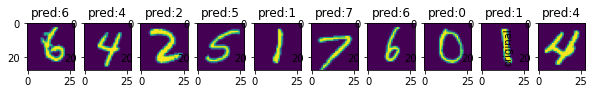

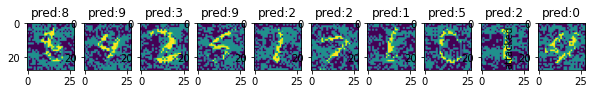

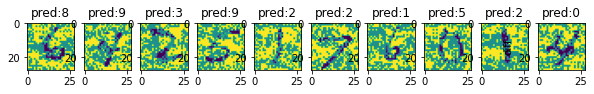

In [89]:
showattacks(attackx, x, attackpreds, origpreds)

In [90]:
evaluate(controlmodel, test_loader, T1, device)

Test accuracy :	 0.9755


9755

In [91]:
attackx, x, attackpreds, origpreds, truthlabels = attack(controlmodel, controltest, epsilon=0.5, attacks=10)

original acc :  0.9699999690055847	attacked acc :  0.0
original acc :  1.0	attacked acc :  0.009999999776482582
original acc :  0.9399999976158142	attacked acc :  0.009999999776482582
original acc :  0.9599999785423279	attacked acc :  0.009999999776482582
original acc :  0.949999988079071	attacked acc :  0.009999999776482582
original acc :  0.9699999690055847	attacked acc :  0.009999999776482582
original acc :  0.9300000071525574	attacked acc :  0.0
original acc :  0.949999988079071	attacked acc :  0.0
original acc :  0.9599999785423279	attacked acc :  0.009999999776482582
original acc :  0.9899999499320984	attacked acc :  0.009999999776482582


In [92]:
np.sum([ax.size(0) for ax in attackx])

955

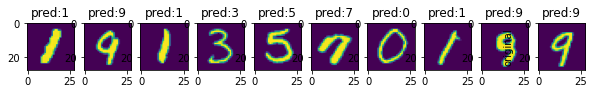

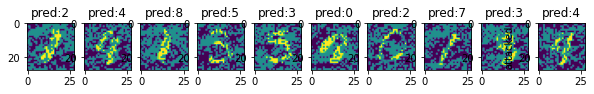

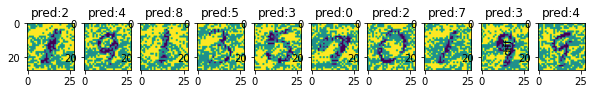

In [93]:
showattacks(attackx, x, attackpreds, origpreds)

In [54]:
from EP_attacks import art_PGD_EP
from EP_attacks.pytorch import PyTorchClassifier

In [33]:
import IPython

In [ ]:
delbigrecurse(fakemodel)

energyModelWrapper(
  (model): fake_softmax_CNN(
    (synapses): ModuleList(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      (4): Linear(in_features=512, out_features=10, bias=True)
    )
    (lat_syn): ModuleList(
      (0): Linear(in_features=10, out_features=10, bias=True)
    )
    (criterion): MSELoss()
  )
)
T 28
250
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
_

__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
c

__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__del

__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattr

__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 4

__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__

__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subcla

__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_le

__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__ls

__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__

__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__

__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__

__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of in

__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 5

__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56


__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56

__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
_

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduc

__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x

__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denomina

__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__

__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 

__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__has

__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
_

__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__flo

__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 

__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpo

__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56


__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__in

__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
_

__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 

__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduc

__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor

__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>

__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63

__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conj

__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 5

__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__i

__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<b

__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 

__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__inde

__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 5

__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
_

__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__ge

__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor

__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__h

__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 7

__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b

__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__

__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__ge

__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56


__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__inde

__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 

__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 5

__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__i

__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 4

__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 

__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56


__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__r

__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__r

__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__i

__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floor

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62


__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init

__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattr

__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 5

__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 

__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rs

__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash

__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__

__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__h

__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72


__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex

__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
_

__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object a

__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__

__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
_

__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new

__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__i

__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclas

__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__flo

__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qua

__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 

__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b

__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conj

__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex

__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
_

__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
_

__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qua

__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt

__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor

__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new

__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__

<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class

__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72


__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96


__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__

__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__flo

__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56


__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__

__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56


__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__

__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshif

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
_

__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59


__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72

__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56

__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56


__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96


__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qua

__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object a

__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__r

__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__

__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floor

__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le

__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__ne

__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init

__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 5

__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 7

__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex

__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt

__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 

__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor

__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__

__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96


__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 5

__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__del

__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 7

__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__h

__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclas

__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floor

__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
c

denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getat

__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshif

__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclas

__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28

__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 5

__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt

__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__

__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56

__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__fl

__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denomina

__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__ne

__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72


__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56

__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor_

__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__

__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__ini

__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56


__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56


__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56


__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__i

__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 5

__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 5

__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__ini

__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash

__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool

__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28

__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length o

__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_sig

__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62


bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__cei

__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56


__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 5

__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63

__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 7

__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rs

__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__

__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_s

__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__

__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt

__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72

__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpo

__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>

__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72

__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor_

__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__

__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_sig

__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_s

__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 

denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getat

__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshif

__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 

__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__

__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28

__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class_

__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
_

__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__tr

__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new

__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__

__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__ne

__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59
__ne__ 56
__new__ 72
__qualname__ 63
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x

__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 174
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 59


__text_signature__ 16
conjugate 72
<built-in method conjugate of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 56
__dir__ 72
__doc__ 96
__eq__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__gt__ 56
__hash__ 56
__init__ 56
__init_subclass__ 72
__le__ 56
__lt__ 56
__module__ 16
__name__ 58
__ne__ 56
__new__ 72
__qualname__ 62
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__self__ 28
__setattr__ 56
__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduc

__sizeof__ 72
__str__ 56
__subclasshook__ 72
__text_signature__ 16
denominator 28
1
__abs__ 56
__add__ 56
__and__ 56
__bool__ 56
__ceil__ 72
__class__ 400
__delattr__ 56
__dir__ 72
__divmod__ 56
__doc__ 654
__eq__ 56
__float__ 56
__floor__ 72
__floordiv__ 56
__format__ 72
__ge__ 56
__getattribute__ 56
__getnewargs__ 72
__gt__ 56
__hash__ 56
__index__ 56
__init__ 56
__init_subclass__ 72
__int__ 56
__invert__ 56
__le__ 56
__lshift__ 56
__lt__ 56
__mod__ 56
__mul__ 56
__ne__ 56
__neg__ 56
__new__ 72
__or__ 56
__pos__ 56
__pow__ 56
__radd__ 56
__rand__ 56
__rdivmod__ 56
__reduce__ 72
__reduce_ex__ 72
__repr__ 56
__rfloordiv__ 56
__rlshift__ 56
__rmod__ 56
__rmul__ 56
__ror__ 56
__round__ 72
__rpow__ 56
__rrshift__ 56
__rshift__ 56
__rsub__ 56
__rtruediv__ 56
__rxor__ 56
__setattr__ 56
__sizeof__ 72
__str__ 56
__sub__ 56
__subclasshook__ 72
__truediv__ 56
__trunc__ 72
__xor__ 56
bit_length 72
<built-in method bit_length of int object at 0x564dbb2a9b40>
__call__ 56
__class__ 400
__delattr__ 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/rstrauss/anaconda3/envs/EP/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1036454ca455>", line 1, in <module>
    delbigrecurse(fakemodel)
  File "<ipython-input-21-f5ae0c2d1e72>", line 8, in delbigrecurse
    delbigrecurse(v)
  File "<ipython-input-21-f5ae0c2d1e72>", line 8, in delbigrecurse
    delbigrecurse(v)
  File "<ipython-input-21-f5ae0c2d1e72>", line 8, in delbigrecurse
    delbigrecurse(v)
  [Previous line repeated 1235 more times]
  File "<ipython-input-21-f5ae0c2d1e72>", line 6, in delbigrecurse
    print(k, sys.getsizeof(v))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rstrauss/anaconda3/envs/EP/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/rstrauss/anaconda3/envs/EP/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-1036454ca455>", line 1, in <module>
    delbigrecurse(fakemodel)
  File "<ipython-input-21-f5ae0c2d1e72>", line 8, in delbigrecurse
    delbigrecurse(v)
  File "<ipython-input-21-f5ae0c2d1e72>", line 8, in delbigrecurse
    delbigrecurse(v)
  File "<ipython-input-21-f5ae0c2d1e72>", line 8, in delbigrecurse
    delbigrecurse(v)
  [Previous line repeated 1235 more times]
  File "<ipython-input-21-f5ae0c2d1e72>", line 6, in delbigrecurse
    print(k, sys.getsizeof(v))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rstrauss/anaconda3/envs/EP/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback

In [35]:
IPython.kernel

AttributeError: module 'IPython' has no attribute 'kernel'